##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

First we read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import numpy as np
train_data = pd.read_csv("C:\\Users\\Ash Azarhoush\\Desktop\\Machine Learning Ass2\\Train.csv", sep=',')
test_data = pd.read_csv("C:\\Users\\Ash Azarhoush\\Desktop\\Machine Learning Ass2\\Test.csv", sep=',')
train_data = train_data.iloc[: , 1:]


Then we separate the tweet text and the label (sentiment). 

In [2]:
# separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

# separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

# Untouched data 
Xtrain_clean = X_train_raw

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [3]:
# Let's see one example tweet
print(X_train_raw[55])

 so my research paper is on minimum wage. there is literally so much i could write abt this subject but that's what's making it so hard üò≠


### Cleaning the Data and Tokenization
We remove stop words, web links, numbers, non-letters, mentions and accent marks. We also lemmitize and tokenize the data

In [4]:
#Please use "!pip install gensim" to install the "gensim" library
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import unidecode
import re
import nltk

# Removing web links and mentions using regex
j = 0
for i in X_train_raw:
    i = re.sub(r"(?:\@|https?\://)\S+", "", i) 
    X_train_raw[j] = i
    j = j + 1
j = 0
for i in X_test_raw:
    i = re.sub(r"(?:\@|https?\://)\S+", "", i)
    X_test_raw[j] = i
    j = j + 1

# Tokenize using a punkt tokenizer
X_train_token = []
X_test_token = []
for i in X_train_raw:
    X_train_token.append(wordpunct_tokenize(i))
for i in X_test_raw:
    X_test_token.append(wordpunct_tokenize(i))

# Lemmitize the data
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
for i in X_train_token:
    k = 0
    for j in i:
        i[k] = lemmatizer.lemmatize(j)
        k = k + 1
for i in X_test_token:
    k = 0
    for j in i:
        i[k] = lemmatizer.lemmatize(j)
        k = k + 1

# Removing stop words, numbers, non-letters, accent marks and turning all words lowercase 
for i in X_train_token:
    k = 0
    for j in i:
        j = j.lower()
        j = remove_stopwords(j)
        j = ''.join([k for k in j if not k.isdigit()]) 
        j = re.sub(r'[^\w\s]', '', j) #using regex to remove anything that is not alphanumeric
        j = unidecode.unidecode(j)
        i[k] = j
        k = k + 1    
for i in X_test_token:
    k = 0
    for j in i:
        j = j.lower()
        j = remove_stopwords(j)
        j = ''.join([k for k in j if not k.isdigit()]) 
        j = re.sub(r'[^\w\s]', '', j) #using regex to remove anything that is not alphanumeric
        j = unidecode.unidecode(j)
        i[k] = j
        k = k + 1

# Removing left over empty slots in data vectors
k = 0
for i in X_train_token:
    i = [j for j in i if j != '']
    X_train_token[k] = i
    k = k + 1
k = 0
for i in X_test_token:
    i = [j for j in i if j != '']
    X_test_token[k] = i
    k = k + 1

[nltk_data] Downloading package wordnet to C:\Users\Ash
[nltk_data]     Azarhoush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Splitting into Training and Testing Set 

In [12]:
from sklearn.model_selection import train_test_split

# Data for testing performance - split training data into a train and test set
xtrain, xtest, ytrain, ytest = train_test_split(X_train_token, Y_train, test_size = 0.3, random_state = 0, shuffle = True)

# Data for the entire model - Remove hash if testing entire model  
#xtrain = X_train_token
#xtest = X_test_token
#ytrain = Y_train

### Vectorizing - TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Our dataset is already tokenized so an extra step must be taken for the TfidfVectorizer to work. 
# Adapted from https://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
def dummy_fun(doc):
    return doc

# Applying tfidf vectorizer to our train and test sets 
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    ngram_range = (1,2)) # Unigram AND Bigrams to be extracted

# Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
tfidf.fit(xtrain)
xtrainvector = tfidf.transform(xtrain)

# Use the feature set (vocabulary) from Train to vectorise the Test dataset 
xtestvector = tfidf.transform(xtest)


print(xtrainvector.shape)
print(xtestvector.shape)

(15261, 122799)
(6541, 122799)


### TF-IDF for Unprocessed data 

In [40]:
# Unprocessed data split
xtrainU, xtestU, ytrainU, ytestU = train_test_split(Xtrain_clean, Y_train, test_size = 0.3, random_state = 0, shuffle = True)

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2))

xtrainvectorU = tfidf_vectorizer.fit_transform(xtrainU)
xtestvectorU = tfidf_vectorizer.transform(xtestU)

print(xtrainvectorU.shape)
print(xtestvectorU.shape)

(15261, 156520)
(6541, 156520)


### Speed and Accuracy of Unprocessed vs Engineered Features

In [41]:
from sklearn.linear_model import LogisticRegression
from timeit import default_timer as timer

# LR for engineered features 
clflr = LogisticRegression(max_iter=2000)

# Start timer and fit the model
start = timer()
clflr.fit(xtrainvector, ytrain)

# Predict outputs
ypredictedlr = list(clflr.predict(xtestvector))

# End timer and calculate time
end = timer()
time = (end - start) * 1000


# LR for unprocessed features 
clflrU = LogisticRegression(max_iter=2000)

startU = timer()
clflrU.fit(xtrainvectorU, ytrainU)

ypredictedlrU = list(clflrU.predict(xtestvectorU))

endU = timer()
timeU = (endU - startU) * 1000

# Accuracy of both models
accuracyE = accuracy_score(ytest, ypredictedlr) * 100 
accuracyU = accuracy_score(ytestU, ypredictedlrU) * 100

print("Engineered features had accuracy %.3f%% and took %.3f milliseconds." % (accuracyE, time))
print("Unprocessed features had accuracy %.3f%% and took %.3f milliseconds." % (accuracyU, timeU))

Engineered features had accuracy 66.152% and took 5916.162 milliseconds.
Unprocessed features had accuracy 66.106% and took 6914.224 milliseconds.


### Check for Imbalances

In [11]:
from collections import Counter
c = Counter(Y_train)
print("The proportion of positive sentiment in the entire training data =",  c["positive"]/len(Y_train))
print("The proportion of neutral sentiment in the entire training data =", c["neutral"]/len(Y_train))
print("The proportion of negative sentiment in the entire training data =", c["negative"]/len(Y_train))

The proportion of positive sentiment in the entire training data = 0.24896798458856986
The proportion of neutral sentiment in the entire training data = 0.5806348041464086
The proportion of negative sentiment in the entire training data = 0.17039721126502155


There are many more instances of "neutral" sentiment than the other two. We should balance the data set before we fit the models to improve the classification performance of the minority sentiments.

### Fitting Random Classifiers

In [8]:
from sklearn import svm
# Linear support-vector machine
clfSVC = svm.SVC(kernel="linear", class_weight='balanced') #Use "class_weight='balanced'" to balance the dataset

# Train the model on training data
clfSVC.fit(xtrainvector, ytrain) 

# Predict the results from the testing data
ypredictedSVC = list(clfSVC.predict(xtestvector))

In [14]:
# ZeroR Classifier 
prediction = max(set(ytrain), key=ytrain.count)
ypredicted0R = [prediction]*len(ytest)

# use "!pip install -U imbalanced-learn" to install the imblearn library
from imblearn.over_sampling import SMOTE

# Balancing the datasets using the synthetic minority oversampling technique (SMOTE)
sm = SMOTE(random_state = 7)
xtrainvector, ytrain = sm.fit_resample(xtrainvector, ytrain)


# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
clfKNN = KNeighborsClassifier(n_neighbors = 7)

# Train the model on training data
clfKNN.fit(xtrainvector, ytrain)

# Predict the results from the testing data
ypredictedKNN = list(clfKNN.predict(xtestvector))


# Logistic regression classifier
from sklearn.linear_model import LogisticRegression
clflr = LogisticRegression(max_iter=2000)

clflr.fit(xtrainvector, ytrain)

ypredictedlr = list(clflr.predict(xtestvector))


# Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
clfNB = GaussianNB()

clfNB.fit(xtrainvector.toarray(), ytrain)

ypredictedNB = list(clfNB.predict(xtestvector.toarray()))

### Exporting Predicted Results to a CSV

In [22]:
test_final = test_data
test_final["sentiment"] = ypredictedlr
test_final = test_final.drop("text", 1)
compression_opts = dict(method="zip", archive_name="out20.csv")  
test_final.to_csv("out20.zip", index=False, compression=compression_opts)  

C:\Users\ASHAZA~1\AppData\Local\Temp/ipykernel_19196/2463327632.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_final = test_final.drop("text", 1)


### Evaluation Function - Confusion Matrix, Accuracy, F1-score, Label-wise Precision and Recall

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore") # default = warnings on. ignore = warnings off 


def printResults(ytest, ypredicted):
    
    # Confusion matrix of true value vs prediction of test set
    labels = ['positive', 'neutral', 'negative']
    cm = confusion_matrix(ytest, ypredicted)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    precision, recall, fscore, support = score(ytest, ypredicted)

    print("Accuracy= ", accuracy_score(ytest, ypredicted)) # The accuracy score of model
    print("Precision= " , precision) 
    print("Recall= ", recall)
    print("Fscore= ", fscore)
    print('############################################')
    print('############################################')
    print("\n")

### Results of Performance Metrics

Results for 0R:


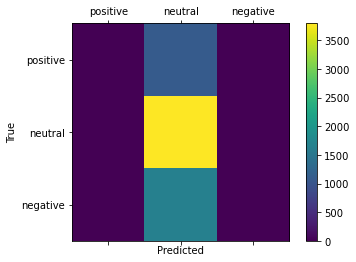

Accuracy=  0.5804922794679712
Precision=  [0.         0.58049228 0.        ]
Recall=  [0. 1. 0.]
Fscore=  [0.         0.73457148 0.        ]
############################################
############################################




In [16]:
print("Results for 0R:")
printResults(ytest, ypredicted0R)

Results for KNN:


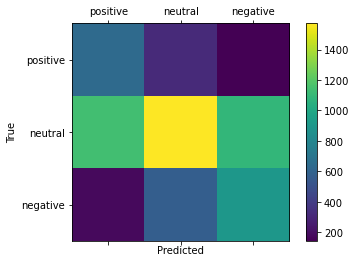

Accuracy=  0.4751567038679101
Precision=  [0.3258312  0.64006515 0.42206573]
Recall=  [0.58279963 0.41401106 0.54451847]
Fscore=  [0.417979   0.50279866 0.47553557]
############################################
############################################




In [17]:
print("Results for KNN:")
printResults(ytest, ypredictedKNN)

Results for Naive Bayes:


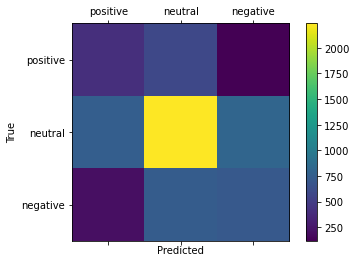

Accuracy=  0.5115425775875249
Precision=  [0.29572271 0.6303491  0.43233313]
Recall=  [0.36688015 0.58967606 0.42761962]
Fscore=  [0.3274806  0.6093346  0.42996346]
############################################
############################################




In [18]:
print("Results for Naive Bayes:")
printResults(ytest, ypredictedNB)

Results for Logistic Regression:


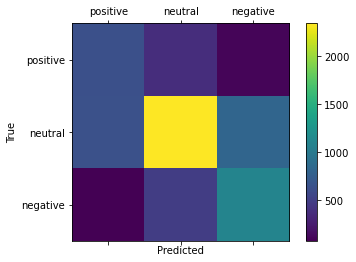

Accuracy=  0.6214646078581256
Precision=  [0.46741573 0.733125   0.54586241]
Recall=  [0.57090576 0.6178562  0.6632344 ]
Fscore=  [0.51400329 0.6705731  0.59885152]
############################################
############################################




In [19]:
print("Results for Logistic Regression:")
printResults(ytest, ypredictedlr)

Results for Linear SVC:


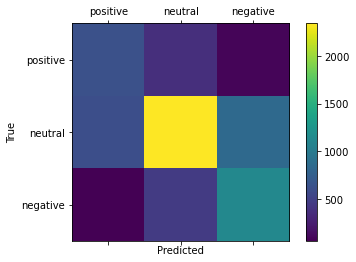

Accuracy=  0.6254395352392601
Precision=  [0.48048967 0.73808772 0.54430993]
Recall=  [0.57456542 0.61601264 0.68079952]
Fscore=  [0.52333333 0.67154752 0.60495156]
############################################
############################################




In [20]:
print("Results for Linear SVC:")
printResults(ytest, ypredictedSVC)